In [1]:
import numpy as np
import pickle
from astropy.io import fits
from astropy.time import Time
from astropy import coordinates as coord
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
class TemporaryAperturePhotometry:
    def __init__(self):
        self.data_path = '/home/alcadis/Desktop/lab2/group13_WASP-12_20230113'

        # Constants
        self.readout_noise = 7.4
        self.gain = 1.91
        self.bias_std = 1.3

        # Loading calibration files
        self.median_bias = pickle.load(open('/home/alcadis/Desktop/lab2/TASTE_analysis/median_bias.p', 'rb'))
        self.median_bias_error = pickle.load(open('/home/alcadis/Desktop/lab2/TASTE_analysis/median_bias_error.p', 'rb'))
        self.median_normalized_flat = pickle.load(open('/home/alcadis/Desktop/lab2/TASTE_analysis/median_normalized_flat.p', 'rb'))
        self.median_normalized_flat_error = pickle.load(open('/home/alcadis/Desktop/lab2/TASTE_analysis/median_normalized_flat_errors.p', 'rb'))

        # Science files
        self.science_path = self.data_path + '/science/'
        self.science_list = np.genfromtxt(self.science_path + 'science.list', dtype=str)
        self.science_size = len(self.science_list)

        # Telescope and target coordinates
        self.telescope_location = ('45.8472d', '11.567d')  # Telescope location (latitude, longitude)
        self.target_coords = coord.SkyCoord('06:30:32.79', '+29:40:20', unit=(u.hourangle, u.deg), frame='icrs')

        # Create meshgrid for distance computations
        ylen, xlen = np.shape(self.median_bias)
        X_axis = np.arange(0, xlen, 1.)
        Y_axis = np.arange(0, ylen, 1.)
        self.X, self.Y = np.meshgrid(X_axis, Y_axis)

    def provide_aperture_parameters(self, sky_inner_radius, sky_outer_radius, aperture_radius, x_initial, y_initial):
        self.sky_inner_radius = sky_inner_radius
        self.sky_outer_radius = sky_outer_radius
        self.aperture_radius = aperture_radius
        self.x_initial = x_initial
        self.y_initial = y_initial

    def correct_science_frame(self, science_data):
        """Correct science frame for bias and flat-fielding."""
        science_debiased = science_data - self.median_bias
        science_corrected = science_debiased / self.median_normalized_flat

        # Error computation
        science_debiased_errors = np.sqrt(self.readout_noise**2 + self.median_bias_error**2 + science_debiased)
        science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + 
                                   (self.median_normalized_flat_error/self.median_normalized_flat)**2)

        return science_corrected, science_corrected_errors

    def compute_centroid(self, science_frame, x_target_initial, y_target_initial, maximum_iterations=20):
        """Refine the centroid position of the target star."""
        x_refined, y_refined = x_target_initial, y_target_initial
        for _ in range(maximum_iterations):
            target_distance = np.sqrt((self.X - x_refined)**2 + (self.Y - y_refined)**2)
            annulus_selection = (target_distance < self.sky_inner_radius)
            
            weighted_X = np.sum(science_frame[annulus_selection] * self.X[annulus_selection])
            weighted_Y = np.sum(science_frame[annulus_selection] * self.Y[annulus_selection])
            total_flux = np.sum(science_frame[annulus_selection])

            x_new = weighted_X / total_flux
            y_new = weighted_Y / total_flux

            if np.abs((x_new - x_refined) / x_refined) < 0.001 and np.abs((y_new - y_refined) / y_refined) < 0.001:
                break

            x_refined, y_refined = x_new, y_new

        return x_refined, y_refined

    def compute_sky_background(self, science_frame, x_pos, y_pos):
        """Calculate sky background using an annulus."""
        target_distance = np.sqrt((self.X - x_pos)**2 + (self.Y - y_pos)**2)
        annulus_selection = (target_distance > self.sky_inner_radius) & (target_distance <= self.sky_outer_radius)

        sky_flux_average = np.sum(science_frame[annulus_selection]) / np.sum(annulus_selection)
        sky_flux_median = np.median(science_frame[annulus_selection])
        
        return sky_flux_median, np.std(science_frame[annulus_selection])

    def convert_jd_to_bjd_tdb(self, jd_array, exptime_array):
        """Convert Julian Date (JD) to Barycentric Julian Date in Barycentric Dynamical Time (BJD_TDB)."""
        # Calculate mid-exposure times
        mid_exposure = jd_array + exptime_array / (2.0 * 86400.0)

        # Create a time object
        time_object = Time(mid_exposure, format='jd', scale='utc', location=self.telescope_location)

        # Compute BJD_TDB by adding the light travel time
        bjd_tdb = time_object.tdb + time_object.light_travel_time(self.target_coords, ephemeris='jpl')
        return bjd_tdb.value

    def aperture_photometry(self):
        """Perform aperture photometry for all science frames."""
        # Initialize result arrays
        self.airmass = np.empty(self.science_size)
        self.exptime = np.empty(self.science_size)
        self.julian_date = np.empty(self.science_size)
        self.bjd_tdb = np.empty(self.science_size)

        self.sky_background = np.empty(self.science_size)
        self.sky_background_errors = np.empty(self.science_size)
        self.aperture_flux = np.empty(self.science_size)
        self.aperture_errors = np.empty(self.science_size)
        self.x_position = np.empty(self.science_size)
        self.y_position = np.empty(self.science_size)

        for i, science_name in enumerate(self.science_list):
            # Load science frame
            science_fits = fits.open(self.science_path + science_name)
            self.airmass[i] = science_fits[0].header['AIRMASS']
            self.exptime[i] = science_fits[0].header['EXPTIME']
            self.julian_date[i] = science_fits[0].header['JD']
            science_data = science_fits[0].data * self.gain
            science_fits.close()

            # Correct science frame
            science_corrected, science_corrected_errors = self.correct_science_frame(science_data)

            # Compute sky background
            sky_median, sky_error = self.compute_sky_background(science_corrected, self.x_initial, self.y_initial)
            self.sky_background[i] = sky_median
            self.sky_background_errors[i] = sky_error

            # Subtract sky background
            science_sky_corrected = science_corrected - sky_median

            # Compute refined centroid
            x_refined, y_refined = self.compute_centroid(science_sky_corrected, self.x_initial, self.y_initial)

            # Perform aperture photometry
            target_distance = np.sqrt((self.X - x_refined)**2 + (self.Y - y_refined)**2)
            aperture_selection = (target_distance < self.aperture_radius)
            self.aperture_flux[i] = np.sum(science_sky_corrected[aperture_selection])

            # Estimate error
            self.aperture_errors[i] = np.sqrt(np.sum(science_corrected_errors[aperture_selection]**2))

            # Save positions
            self.x_position[i] = x_refined
            self.y_position[i] = y_refined

        # Convert JD to BJD_TDB
        self.bjd_tdb = self.convert_jd_to_bjd_tdb(self.julian_date, self.exptime)

    def save_results(self, filename):
        """Save the photometry results to a file."""
        results = {
            'airmass': self.airmass,
            'exptime': self.exptime,
            'bjd_tdb': self.bjd_tdb,
            'sky_background': self.sky_background,
            'aperture_flux': self.aperture_flux,
            'x_position': self.x_position,
            'y_position': self.y_position,
        }
        with open(filename, 'wb') as f:
            pickle.dump(results, f)

In [7]:
from time import time
t0 = time()
target_star = TemporaryAperturePhotometry()
target_star.provide_aperture_parameters(12, 22, 6, 267, 63)
target_star.aperture_photometry()
t1 = time()
print('elapsed_time=', t1-t0)

/tmp/ipykernel_11632/2277834642.py:41: RuntimeWarning: divide by zero encountered in divide
  science_corrected = science_debiased / self.median_normalized_flat
/tmp/ipykernel_11632/2277834642.py:41: RuntimeWarning: invalid value encountered in divide
  science_corrected = science_debiased / self.median_normalized_flat
/tmp/ipykernel_11632/2277834642.py:45: RuntimeWarning: divide by zero encountered in divide
  science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 +
/tmp/ipykernel_11632/2277834642.py:46: RuntimeWarning: divide by zero encountered in divide
  (self.median_normalized_flat_error/self.median_normalized_flat)**2)
/tmp/ipykernel_11632/2277834642.py:45: RuntimeWarning: invalid value encountered in multiply
  science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 +


elapsed_time= 10.67142367362976


In [8]:
from time import time
t0 = time()
reference_star = TemporaryAperturePhotometry()
reference_star.provide_aperture_parameters(12, 22, 6, 80, 60)
reference_star.aperture_photometry()
t1 = time()
print('elapsed_time=', t1-t0)

/tmp/ipykernel_11632/2277834642.py:41: RuntimeWarning: divide by zero encountered in divide
  science_corrected = science_debiased / self.median_normalized_flat
/tmp/ipykernel_11632/2277834642.py:41: RuntimeWarning: invalid value encountered in divide
  science_corrected = science_debiased / self.median_normalized_flat
/tmp/ipykernel_11632/2277834642.py:45: RuntimeWarning: divide by zero encountered in divide
  science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 +
/tmp/ipykernel_11632/2277834642.py:46: RuntimeWarning: divide by zero encountered in divide
  (self.median_normalized_flat_error/self.median_normalized_flat)**2)
/tmp/ipykernel_11632/2277834642.py:45: RuntimeWarning: invalid value encountered in multiply
  science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 +


elapsed_time= 11.507935762405396


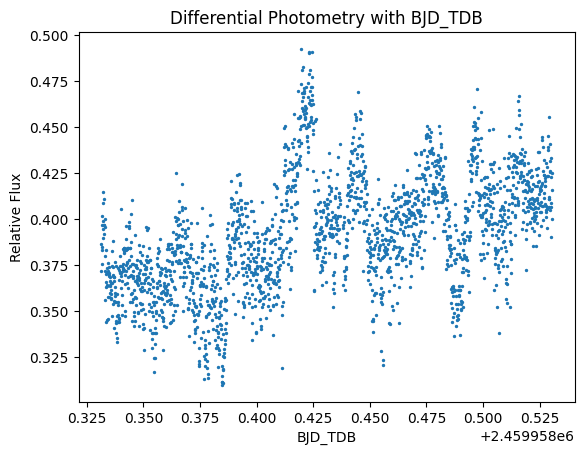

In [9]:
plt.figure()
plt.scatter(target_star.bjd_tdb, target_star.aperture_flux / reference_star.aperture_flux, s=2)
plt.xlabel('BJD_TDB')
plt.ylabel('Relative Flux')
plt.title('Differential Photometry with BJD_TDB')
plt.show()